# Exponential smoothing

Let us consider chapter 7 of the excellent treatise on the subject of Exponential Smoothing By Hyndman and Athanasopoulos [1].
We will work through all the examples in the chapter as they unfold.

[1] [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2014.](https://www.otexts.org/fpp/7)

## Loading data

First we load some data. We have included the R data in the notebook for expedience.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline

data = [
    446.6565,
    454.4733,
    455.663,
    423.6322,
    456.2713,
    440.5881,
    425.3325,
    485.1494,
    506.0482,
    526.792,
    514.2689,
    494.211,
]
index = pd.date_range(start="1996", end="2008", freq="Y")
oildata = pd.Series(data, index)

data = [
    17.5534,
    21.86,
    23.8866,
    26.9293,
    26.8885,
    28.8314,
    30.0751,
    30.9535,
    30.1857,
    31.5797,
    32.5776,
    33.4774,
    39.0216,
    41.3864,
    41.5966,
]
index = pd.date_range(start="1990", end="2005", freq="Y")
air = pd.Series(data, index)

data = [
    263.9177,
    268.3072,
    260.6626,
    266.6394,
    277.5158,
    283.834,
    290.309,
    292.4742,
    300.8307,
    309.2867,
    318.3311,
    329.3724,
    338.884,
    339.2441,
    328.6006,
    314.2554,
    314.4597,
    321.4138,
    329.7893,
    346.3852,
    352.2979,
    348.3705,
    417.5629,
    417.1236,
    417.7495,
    412.2339,
    411.9468,
    394.6971,
    401.4993,
    408.2705,
    414.2428,
]
index = pd.date_range(start="1970", end="2001", freq="Y")
livestock2 = pd.Series(data, index)

data = [407.9979, 403.4608, 413.8249, 428.105, 445.3387, 452.9942, 455.7402]
index = pd.date_range(start="2001", end="2008", freq="Y")
livestock3 = pd.Series(data, index)

data = [
    41.7275,
    24.0418,
    32.3281,
    37.3287,
    46.2132,
    29.3463,
    36.4829,
    42.9777,
    48.9015,
    31.1802,
    37.7179,
    40.4202,
    51.2069,
    31.8872,
    40.9783,
    43.7725,
    55.5586,
    33.8509,
    42.0764,
    45.6423,
    59.7668,
    35.1919,
    44.3197,
    47.9137,
]
index = pd.date_range(start="2005", end="2010-Q4", freq="QS-OCT")
aust = pd.Series(data, index)

/tmp/ipykernel_5726/536270367.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range(start="1996", end="2008", freq="Y")
/tmp/ipykernel_5726/536270367.py:43: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range(start="1990", end="2005", freq="Y")
/tmp/ipykernel_5726/536270367.py:79: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range(start="1970", end="2001", freq="Y")
/tmp/ipykernel_5726/536270367.py:83: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range(start="2001", end="2008", freq="Y")


## Simple Exponential Smoothing
Lets use Simple Exponential Smoothing to forecast the below oil data.

Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.


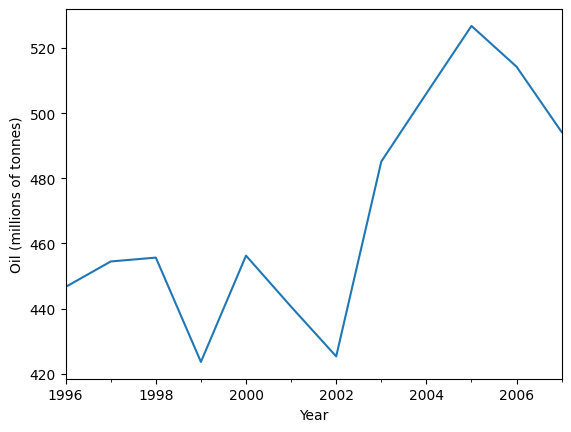

In [2]:
ax = oildata.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Oil (millions of tonnes)")
print("Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.")

Here we run three variants of simple exponential smoothing:
1. In ```fit1``` we do not use the auto optimization but instead choose to explicitly provide the model with the $\alpha=0.2$ parameter
2. In ```fit2``` as above we choose an $\alpha=0.6$
3. In ```fit3``` we allow statsmodels to automatically find an optimized $\alpha$ value for us. This is the recommended approach.

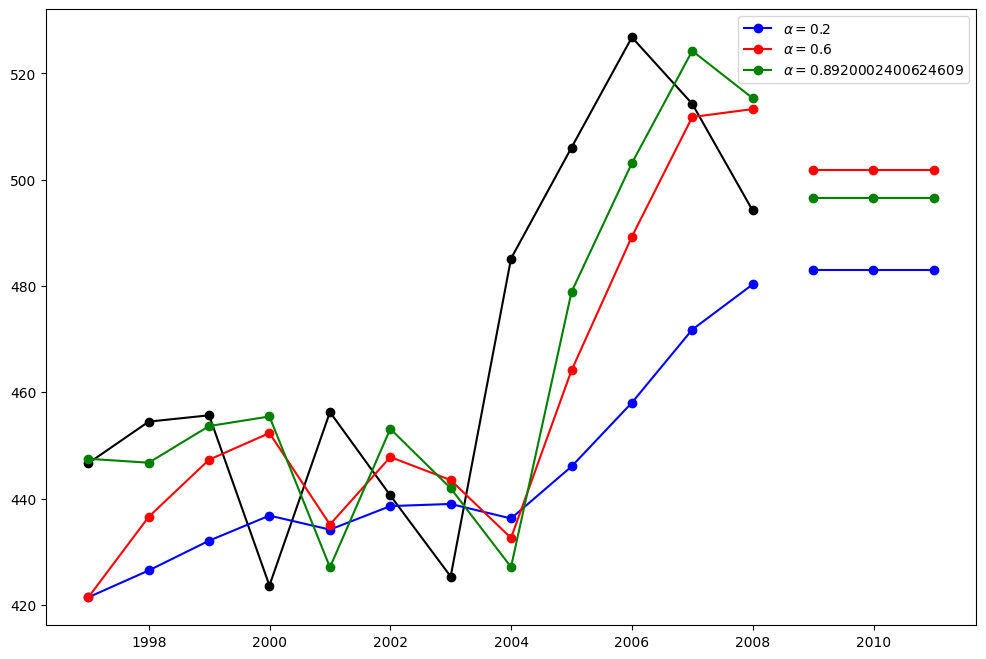

In [3]:
fit1 = SimpleExpSmoothing(oildata, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(oildata, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(oildata, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(oildata, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

## Holt's Method

Lets take a look at another example.
This time we use air pollution data and the Holt's Method.
We will fit three examples again.
1. In ```fit1``` we again choose not to use the optimizer and provide explicit values for $\alpha=0.8$ and $\beta=0.2$
2. In ```fit2``` we do the same as in ```fit1``` but choose to use an exponential model rather than a Holt's additive model.
3. In ```fit3``` we used a damped versions of the Holt's additive model but allow the dampening parameter $\phi$ to be optimized while fixing the values for $\alpha=0.8$ and $\beta=0.2$

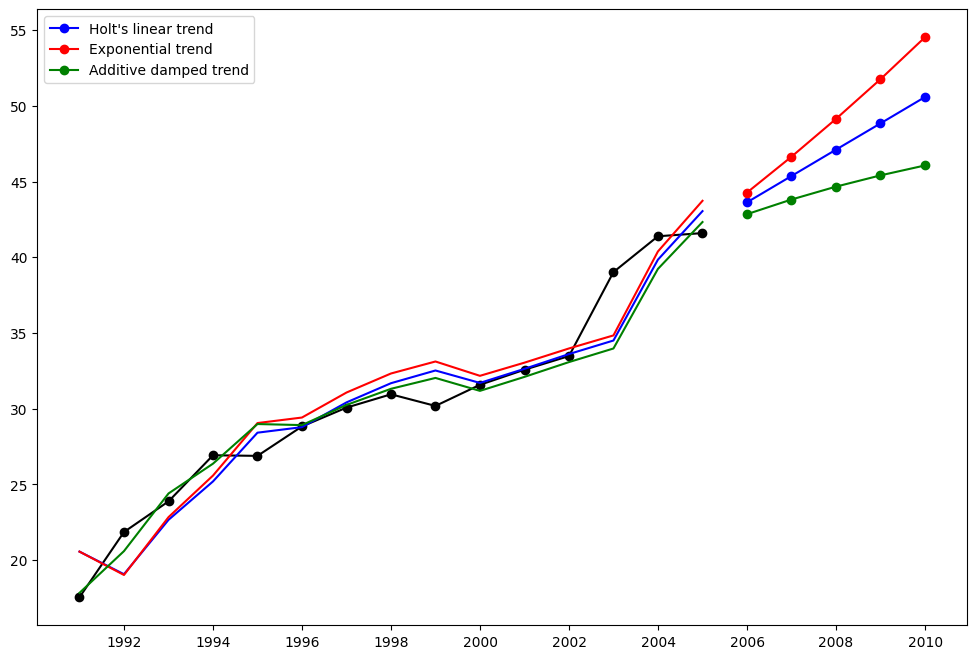

In [4]:
fit1 = Holt(air, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
fit2 = Holt(air, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(5).rename("Exponential trend")
fit3 = Holt(air, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast3 = fit3.forecast(5).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(air, marker="o", color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

### Seasonally adjusted data
Lets look at some seasonally adjusted livestock data. We fit five Holt's models.
The below table allows us to compare results when we use exponential versus additive and damped versus non-damped.
 
Note: ```fit4``` does not allow the parameter $\phi$ to be optimized by providing a fixed value of $\phi=0.98$

In [5]:
fit1 = SimpleExpSmoothing(livestock2, initialization_method="estimated").fit()
fit2 = Holt(livestock2, initialization_method="estimated").fit()
fit3 = Holt(livestock2, exponential=True, initialization_method="estimated").fit()
fit4 = Holt(livestock2, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
fit5 = Holt(
    livestock2, exponential=True, damped_trend=True, initialization_method="estimated"
).fit()
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$", "SSE"],
    columns=["SES", "Holt's", "Exponential", "Additive", "Multiplicative"],
)
results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] = [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,1.000000,0.974338,0.977642,0.978843,0.974912
$\beta$,NaN,0.000000,0.000000,0.000008,0.000000
$\phi$,NaN,NaN,NaN,0.980000,0.981646
$l_0$,263.917703,258.882683,260.335599,257.357716,258.951817
$b_0$,NaN,5.010856,1.013780,6.645297,1.038144
SSE,6761.350235,6004.138207,6104.194782,6036.597169,6081.995045


### Plots of Seasonally Adjusted Data
The following plots allow us to evaluate the level and slope/trend components of the above table's fits.

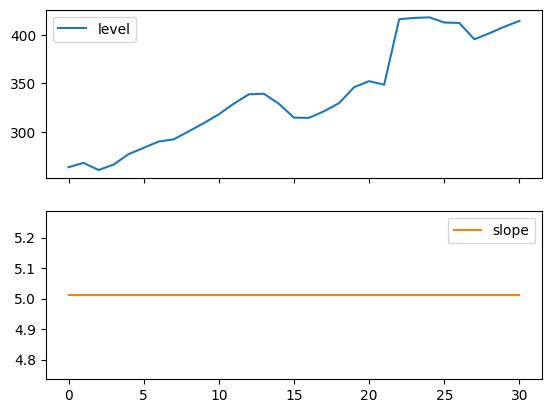

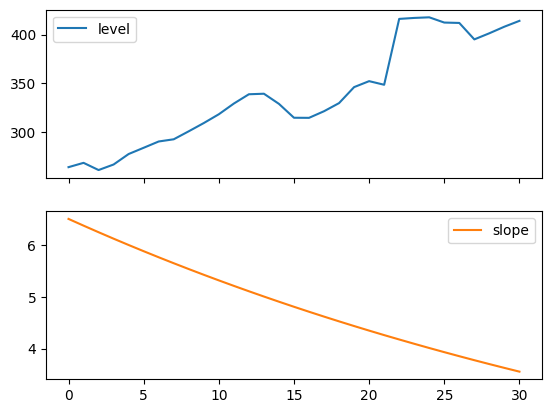

Figure 7.4: Level and slope components for Holt’s linear trend method and the additive damped trend method.


In [6]:
for fit in [fit2, fit4]:
    pd.DataFrame(np.c_[fit.level, fit.trend]).rename(
        columns={0: "level", 1: "slope"}
    ).plot(subplots=True)
plt.show()
print(
    "Figure 7.4: Level and slope components for Holt’s linear trend method and the additive damped trend method."
)

## Comparison
Here we plot a comparison Simple Exponential Smoothing and Holt's Methods for various additive, exponential and damped combinations. All of the models parameters will be optimized by statsmodels.

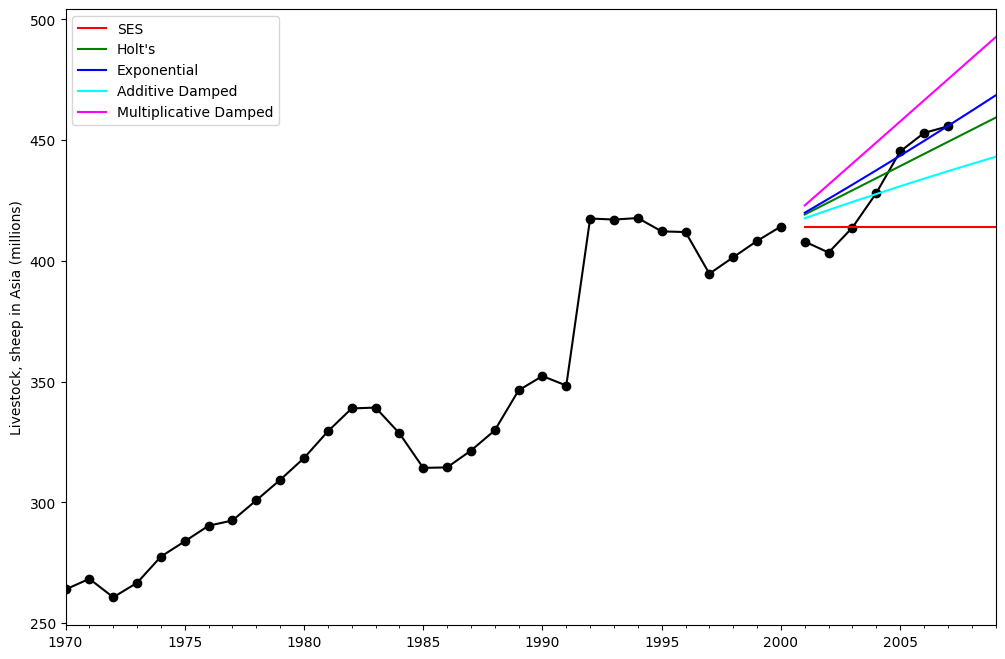

Figure 7.5: Forecasting livestock, sheep in Asia: comparing forecasting performance of non-seasonal methods.


In [7]:
fit1 = SimpleExpSmoothing(livestock2, initialization_method="estimated").fit()
fcast1 = fit1.forecast(9).rename("SES")
fit2 = Holt(livestock2, initialization_method="estimated").fit()
fcast2 = fit2.forecast(9).rename("Holt's")
fit3 = Holt(livestock2, exponential=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(9).rename("Exponential")
fit4 = Holt(livestock2, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
fcast4 = fit4.forecast(9).rename("Additive Damped")
fit5 = Holt(
    livestock2, exponential=True, damped_trend=True, initialization_method="estimated"
).fit()
fcast5 = fit5.forecast(9).rename("Multiplicative Damped")

ax = livestock2.plot(color="black", marker="o", figsize=(12, 8))
livestock3.plot(ax=ax, color="black", marker="o", legend=False)
fcast1.plot(ax=ax, color="red", legend=True)
fcast2.plot(ax=ax, color="green", legend=True)
fcast3.plot(ax=ax, color="blue", legend=True)
fcast4.plot(ax=ax, color="cyan", legend=True)
fcast5.plot(ax=ax, color="magenta", legend=True)
ax.set_ylabel("Livestock, sheep in Asia (millions)")
plt.show()
print(
    "Figure 7.5: Forecasting livestock, sheep in Asia: comparing forecasting performance of non-seasonal methods."
)

## Holt's Winters Seasonal
Finally we are able to run full Holt's Winters Seasonal Exponential Smoothing  including a trend component and a seasonal component.
statsmodels allows for all the combinations including as shown in the examples below:
1. ```fit1``` additive trend, additive seasonal of period ```season_length=4``` and the use of a Box-Cox transformation.
1. ```fit2``` additive trend, multiplicative seasonal of period ```season_length=4``` and the use of a Box-Cox transformation..
1. ```fit3``` additive damped trend, additive seasonal of period ```season_length=4``` and the use of a Box-Cox transformation.
1. ```fit4``` additive damped trend, multiplicative seasonal of period ```season_length=4``` and the use of a Box-Cox transformation.

The plot shows the results and forecast for ```fit1``` and ```fit2```.
The table allows us to compare the results and parameterizations.

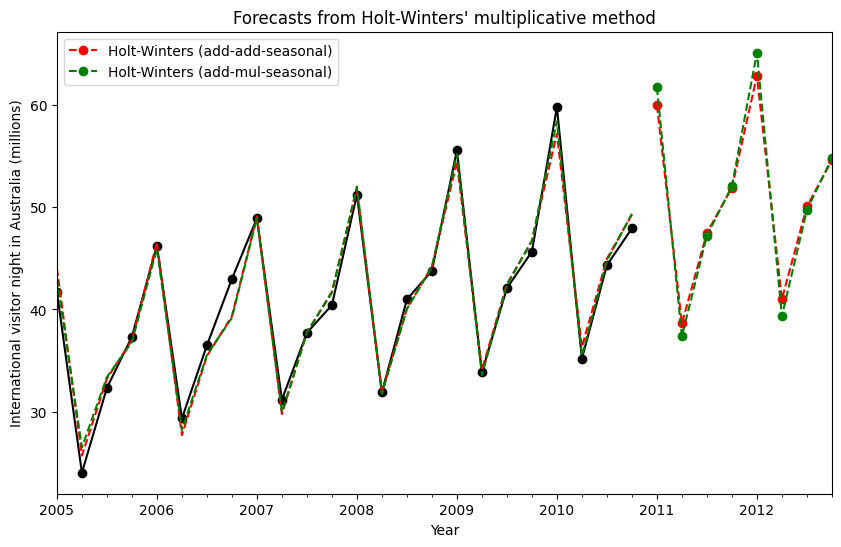

Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08
$\beta$,1.409863e-08,1.991941e-23,6.490682e-09,5.042070e-09
$\phi$,NaN,NaN,9.430416e-01,9.536044e-01
$\gamma$,0.000000e+00,5.880501e-16,5.696125e-16,1.225286e-15
$l_0$,1.119348e+01,1.106378e+01,1.084022e+01,9.899307e+00
$b_0$,1.205396e-01,1.198959e-01,2.456750e-01,1.975449e-01
SSE,4.402746e+01,3.611262e+01,3.527620e+01,3.062033e+01


In [8]:
fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()
print(
    "Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality."
)

results

### The Internals
It is possible to get at the internals of the Exponential Smoothing models. 

Here we show some tables that allow you to view side by side the original values $y_t$, the level $l_t$, the trend $b_t$, the season $s_t$ and the fitted values $\hat{y}_t$. Note that these values only have meaningful values in the space of your original data if the fit is performed without a Box-Cox transformation.

In [9]:
fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()

In [10]:
df = pd.DataFrame(
    np.c_[aust, fit1.level, fit1.trend, fit1.season, fit1.fittedvalues],
    columns=[r"$y_t$", r"$l_t$", r"$b_t$", r"$s_t$", r"$\hat{y}_t$"],
    index=aust.index,
)
forecasts = fit1.forecast(8).rename(r"$\hat{y}_t$").to_frame()
df = pd.concat([df, forecasts], axis=0, sort=True)

In [11]:
df = pd.DataFrame(
    np.c_[aust, fit2.level, fit2.trend, fit2.season, fit2.fittedvalues],
    columns=[r"$y_t$", r"$l_t$", r"$b_t$", r"$s_t$", r"$\hat{y}_t$"],
    index=aust.index,
)
forecasts = fit2.forecast(8).rename(r"$\hat{y}_t$").to_frame()
df = pd.concat([df, forecasts], axis=0, sort=True)

Finally lets look at the levels, slopes/trends and seasonal components of the models.

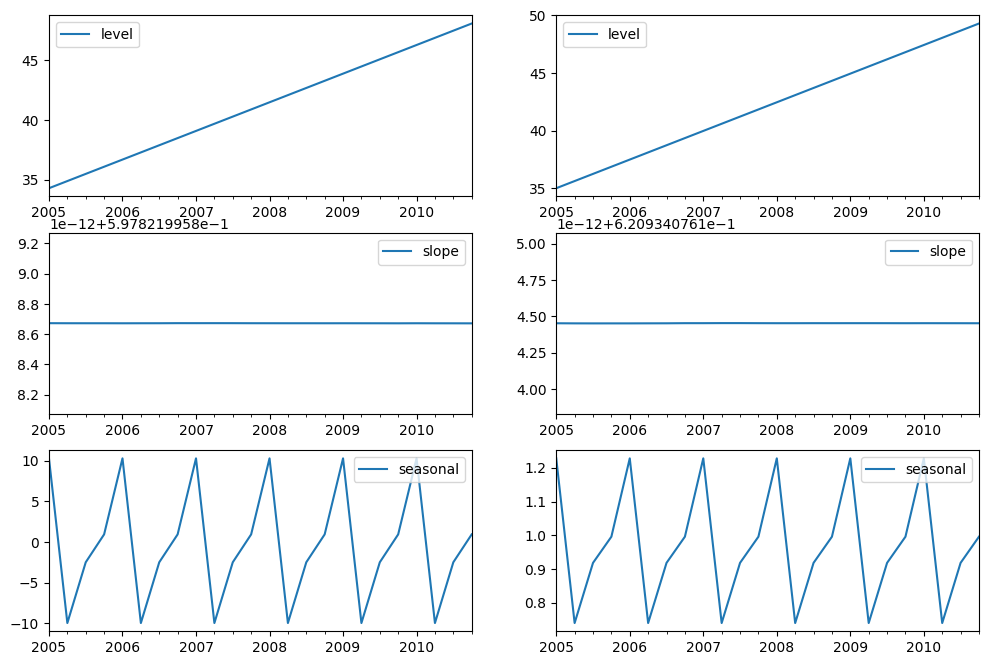

In [12]:
states1 = pd.DataFrame(
    np.c_[fit1.level, fit1.trend, fit1.season],
    columns=["level", "slope", "seasonal"],
    index=aust.index,
)
states2 = pd.DataFrame(
    np.c_[fit2.level, fit2.trend, fit2.season],
    columns=["level", "slope", "seasonal"],
    index=aust.index,
)
fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(12, 8))
states1[["level"]].plot(ax=ax1)
states1[["slope"]].plot(ax=ax2)
states1[["seasonal"]].plot(ax=ax3)
states2[["level"]].plot(ax=ax4)
states2[["slope"]].plot(ax=ax5)
states2[["seasonal"]].plot(ax=ax6)
plt.show()

# Simulations and Confidence Intervals

By using a state space formulation, we can perform simulations of future values. The mathematical details are described in Hyndman and Athanasopoulos [2] and in the documentation of `HoltWintersResults.simulate`.

Similar to the example in [2], we use the model with additive trend, multiplicative seasonality, and multiplicative error. We simulate up to 8 steps into the future, and perform 1000 simulations. As can be seen in the below figure, the simulations match the forecast values quite well.

[2] [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice, 2nd edition. OTexts, 2018.](https://otexts.com/fpp2/ets.html)

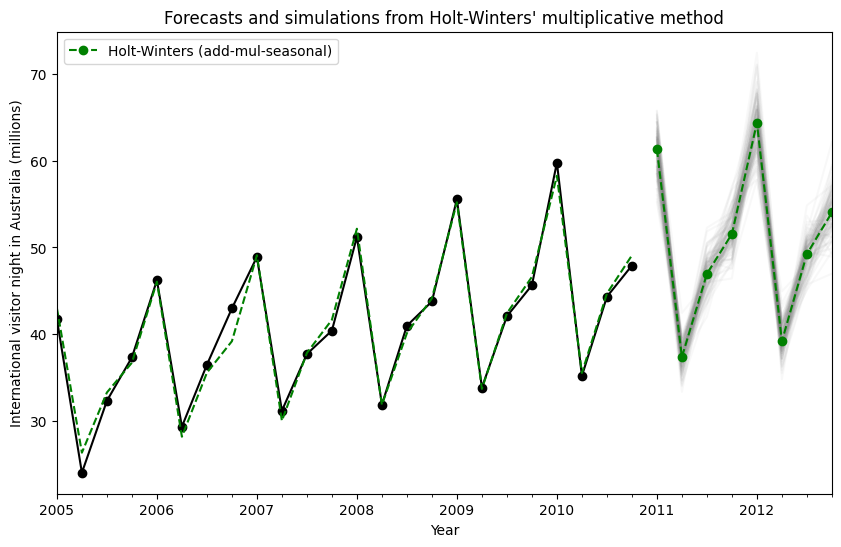

In [13]:
fit = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()
simulations = fit.simulate(8, repetitions=100, error="mul")

ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

Simulations can also be started at different points in time, and there are multiple options for choosing the random noise.

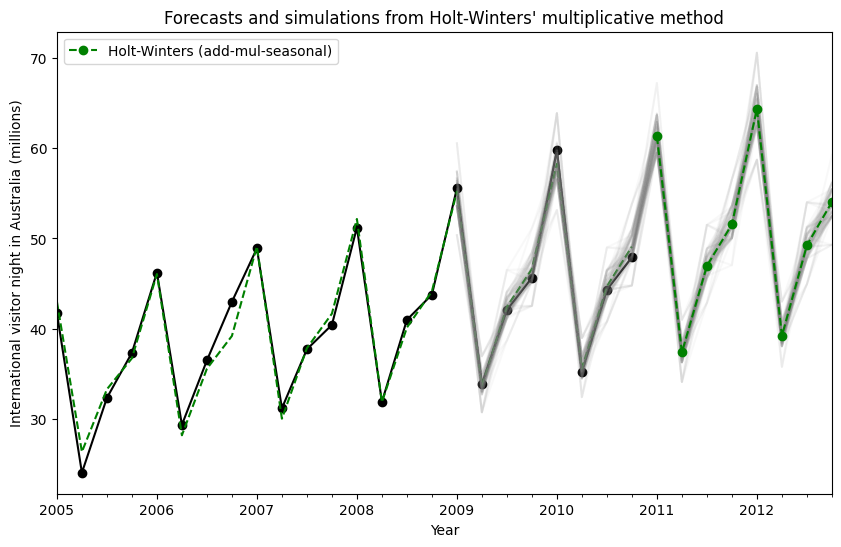

In [14]:
fit = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()
simulations = fit.simulate(
    16, anchor="2009-01-01", repetitions=100, error="mul", random_errors="bootstrap"
)

ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()